# **Aprendizaje por refuerzo**

In [6]:
# Cuadernillo: Agente que aprende a jugar Cuatro en Raya con Q-Learning

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [7]:
# -----------------------------
# 1. Definición del entorno
# -----------------------------

FILAS = 6
COLUMNAS = 7

class CuatroEnRaya:
    def __init__(self):
        self.tablero = np.zeros((FILAS, COLUMNAS), dtype=int)
        self.jugador_actual = 1  # 1 = agente, -1 = oponente

    def reset(self):
        """Reinicia el tablero al estado inicial."""
        self.tablero.fill(0)
        self.jugador_actual = 1
        return self._get_estado()

    def _get_estado(self):
        """Devuelve el estado actual como una tupla hashable."""
        return tuple(map(tuple, self.tablero))

    def acciones_disponibles(self):
        """Lista de columnas válidas para colocar una ficha."""
        return [col for col in range(COLUMNAS) if self.tablero[0][col] == 0]

    def aplicar_accion(self, accion):
        """Aplica una acción (coloca una ficha en una columna)."""
        for fila in reversed(range(FILAS)):
            if self.tablero[fila][accion] == 0:
                self.tablero[fila][accion] = self.jugador_actual
                break

        terminado = self._hay_ganador(self.jugador_actual) or self._esta_lleno()
        recompensa = 1 if self._hay_ganador(self.jugador_actual) else 0

        estado_anterior = self._get_estado()
        self.jugador_actual *= -1
        return estado_anterior, recompensa, terminado

    def _esta_lleno(self):
        """Verifica si el tablero está lleno (empate)."""
        return np.all(self.tablero != 0)

    def _hay_ganador(self, jugador):
        """Revisa si el jugador actual ganó."""
        for c in range(COLUMNAS - 3):
            for f in range(FILAS):
                if all(self.tablero[f][c + i] == jugador for i in range(4)):
                    return True

        for c in range(COLUMNAS):
            for f in range(FILAS - 3):
                if all(self.tablero[f + i][c] == jugador for i in range(4)):
                    return True

        for c in range(COLUMNAS - 3):
            for f in range(FILAS - 3):
                if all(self.tablero[f + i][c + i] == jugador for i in range(4)):
                    return True

        for c in range(COLUMNAS - 3):
            for f in range(3, FILAS):
                if all(self.tablero[f - i][c + i] == jugador for i in range(4)):
                    return True

        return False

In [8]:
# -----------------------------
# 2. Agente con Q-Learning
# -----------------------------

class AgenteQLearning:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.q = defaultdict(lambda: np.zeros(COLUMNAS))
        self.alpha = alpha  # tasa de aprendizaje
        self.gamma = gamma  # factor de descuento
        self.epsilon = epsilon  # probabilidad de exploración

    def elegir_accion(self, estado, acciones_validas):
        """Elige una acción usando la política ε-greedy."""
        if random.random() < self.epsilon:
            return random.choice(acciones_validas)

        q_vals = self.q[estado].copy()
        q_vals[[i for i in range(COLUMNAS) if i not in acciones_validas]] = -np.inf
        return int(np.argmax(q_vals))

    def actualizar(self, estado, accion, recompensa, siguiente_estado, terminado, acciones_validas):
        """Actualiza el valor Q usando la ecuación de Bellman."""
        max_q = 0 if terminado else max(self.q[siguiente_estado][a] for a in acciones_validas)
        actual = self.q[estado][accion]
        self.q[estado][accion] += self.alpha * (recompensa + self.gamma * max_q - actual)


In [9]:
# -----------------------------
# 3. Entrenamiento
# -----------------------------

entorno = CuatroEnRaya()
agente = AgenteQLearning()
num_episodios = 10000
recompensas = []
victorias_agente = 0

for episodio in range(num_episodios):
    estado = entorno.reset()
    terminado = False
    historial = []

    while not terminado:
        acciones = entorno.acciones_disponibles()
        if entorno.jugador_actual == 1:
            accion = agente.elegir_accion(estado, acciones)
        else:
            accion = random.choice(acciones)

        nuevo_estado, recompensa, terminado = entorno.aplicar_accion(accion)

        if entorno.jugador_actual == -1 and recompensa == 1:
            recompensa = -1  # Si el agente ganó antes de cambiar jugador, es positivo
            victorias_agente += 1

        if entorno.jugador_actual == -1:
            agente.actualizar(estado, accion, recompensa, nuevo_estado, terminado, entorno.acciones_disponibles())

        estado = nuevo_estado

    recompensas.append(recompensa)


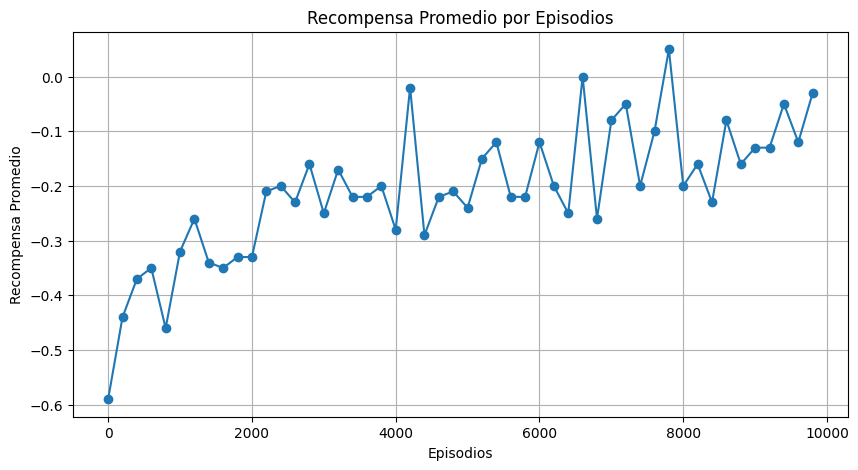

Total de victorias del agente: 6047 / 10000


In [10]:
# -----------------------------
# 4. Evaluación y visualización
# -----------------------------

ventana = 200
promedios = [np.mean(recompensas[i:i+ventana]) for i in range(0, len(recompensas), ventana)]

plt.figure(figsize=(10, 5))
plt.plot(range(0, len(recompensas), ventana), promedios, marker='o')
plt.title("Recompensa Promedio por Episodios")
plt.xlabel("Episodios")
plt.ylabel("Recompensa Promedio")
plt.grid(True)
plt.show()

print(f"Total de victorias del agente: {victorias_agente} / {num_episodios}")